In [ ]:
!pip install openpyxl

In [ ]:
from google.colab import files
import io
uploaded = files.upload()
print(uploaded.keys())
filename = list(uploaded.keys())[0]
print("Loaded file:", filename)

df = pd.read_excel(io.BytesIO(uploaded[filename]))
df.head()
df.info()

Saving df_clean_zones.xlsx to df_clean_zones (4).xlsx
dict_keys(['df_clean_zones (4).xlsx'])
Loaded file: df_clean_zones (4).xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2456 entries, 0 to 2455
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Incident type   2456 non-null   object        
 1   Location        2456 non-null   object        
 2   Date Reported   2456 non-null   datetime64[ns]
 3   Incident/Case#  2456 non-null   object        
 4   Date Occurred   2456 non-null   object        
 5   Time Occurred   2455 non-null   object        
 6   Summary         1211 non-null   object        
 7   Disposition     2456 non-null   object        
 8   Zone            2456 non-null   object        
 9   Polygon Zone    2456 non-null   object        
dtypes: datetime64[ns](1), object(9)
memory usage: 192.0+ KB


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportion_confint

plt.rcParams['figure.figsize'] = (8, 4)

# file_path = "/content/drive/MyDrive/DSC 190 Project/Cleaned CSV/df_clean_zones.xlsx"

# df = pd.read_excel(file_path)
# import io
# df = pd.read_excel(io.BytesIO(uploaded["df_clean_zones.xlsx"]))

# df.head()
# df.info()


In [ ]:

# Keep only on-campus incidents if we want to exclude off-campus
if "Zone" in df.columns:
    df = df[df["Zone"] != "Off Campus"].copy()

# Parse datetime from Date Occurred + Time Occurred
# Adjust column names if your file uses slightly different names
df["datetime_occurred"] = pd.to_datetime(
    df["Date Occurred"].astype(str) + " " + df["Time Occurred"].astype(str),
    errors="coerce"
)

# Day of week, hour
df["day_of_week"] = df["datetime_occurred"].dt.day_name()
df["hour"] = df["datetime_occurred"].dt.hour

# Bin hours into time-of-day categories
def time_of_day_from_hour(h):
    if pd.isna(h):
        return np.nan
    h = int(h)
    if 0 <= h < 6:
        return "Late Night (12–6am)"
    elif 6 <= h < 12:
        return "Morning (6am–12pm)"
    elif 12 <= h < 18:
        return "Afternoon (12–6pm)"
    else:
        return "Evening (6pm–12am)"

df["time_of_day"] = df["hour"].apply(time_of_day_from_hour)

print(df["day_of_week"].value_counts())
print(df["time_of_day"].value_counts())
print(df["Zone"].value_counts())

/tmp/ipython-input-1939567299.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["datetime_occurred"] = pd.to_datetime(


day_of_week
Friday       250
Thursday     232
Wednesday    224
Monday       197
Saturday     189
Tuesday      184
Sunday       150
Name: count, dtype: int64
time_of_day
Evening (6pm–12am)     482
Afternoon (12–6pm)     435
Morning (6am–12pm)     288
Late Night (12–6am)    221
Name: count, dtype: int64
Zone
Main        390
Med         214
Sixth       173
Marshall    159
Warren      137
Revelle     100
Muir         85
Eighth       77
ERC          58
Seventh      48
Name: count, dtype: int64


In [ ]:
# Choose top incident types by frequency (we can change N)
N_TOP = 10
top_types = df["Incident type"].value_counts().head(N_TOP).index

df_top = df[df["Incident type"].isin(top_types)].copy()

# Contingency table: Incident type vs Zone
ct_loc_type = pd.crosstab(df_top["Incident type"], df_top["Zone"])
print(ct_loc_type)

chi2, p, dof, expected = chi2_contingency(ct_loc_type)
print("\nChi-square test: Incident type vs Zone")
print(f"chi2 = {chi2:.2f}, dof = {dof}, p-value = {p:.4g}")


Zone                                     ERC  Eighth  Main  Marshall  Med  \
Incident type                                                               
Elevator Problem                           0       1    10        15    8   
Fire Alarm                                 4      17    13        12    9   
Incomplete/Accidental Landline 911 Call    1       4    29        25    7   
Incomplete/Accidental Wireless 911 Call    2       5    21         2    7   
Medical Aid                                5       4    19         6   47   
Noise Disturbance                         13       9    14        15    0   
Petty Theft - Micro Mobility Device        0       1    16         5    4   
Security Alarm                             0       0    21         5    2   
Suspicious Person                          3       2    22         3    6   
Welfare Check                              1       3    26         3   14   

Zone                                     Muir  Revelle  Seventh  Sixth  War

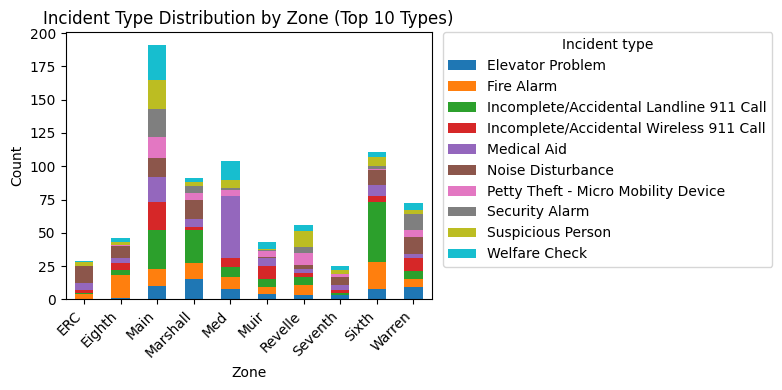

In [ ]:
ax = ct_loc_type.T.plot(kind="bar", stacked=True)

ax.set_title("Incident Type Distribution by Zone (Top 10 Types)")
ax.set_ylabel("Count")
ax.set_xlabel("Zone")

plt.xticks(rotation=45, ha="right")

# Legend to the right
ax.legend(title="Incident type",
          bbox_to_anchor=(1.03, 1),
          loc="upper left",
          borderaxespad=0.)

plt.tight_layout()
plt.show()


In [ ]:
import re


df["is_theft"] = df["Incident type"].str.contains("theft", flags=re.IGNORECASE, na=False).astype(int)

print(df["is_theft"].mean())  # overall proportion

# Drop rows missing key predictors
model_df = df.dropna(subset=["is_theft", "Zone", "day_of_week", "time_of_day"]).copy()

# Use statsmodels logistic regression with categorical predictors
import statsmodels.formula.api as smf

# Reference categories will be chosen automatically (alphabetically) for C(...)
logit_model = smf.logit(
    "is_theft ~ C(Zone) + C(day_of_week) + C(time_of_day)",
    data=model_df
).fit()

print(logit_model.summary())


0.11242192921582235
Optimization terminated successfully.
         Current function value: 0.326409
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:               is_theft   No. Observations:                 1426
Model:                          Logit   Df Residuals:                     1407
Method:                           MLE   Df Model:                           18
Date:                Tue, 02 Dec 2025   Pseudo R-squ.:                 0.07413
Time:                        22:31:44   Log-Likelihood:                -465.46
converged:                       True   LL-Null:                       -502.73
Covariance Type:            nonrobust   LLR p-value:                 7.613e-09
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                         

day_of_week
Monday       197
Tuesday      184
Wednesday    224
Thursday     232
Friday       250
Saturday     189
Sunday       150
Name: count, dtype: int64

Counts by day of week:
day_of_week
Monday       197
Tuesday      184
Wednesday    224
Thursday     232
Friday       250
Saturday     189
Sunday       150
Name: count, dtype: int64

Chi-square GOF vs uniform:
chi2 = 33.82, dof = 6, p = 7.291e-06


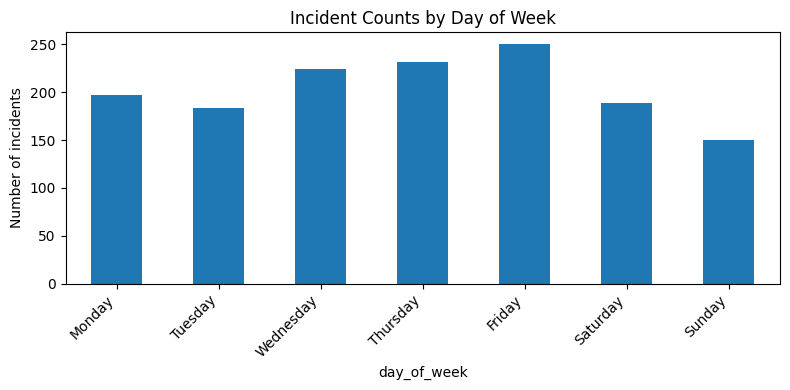

In [ ]:
# Count incidents per day of week
dow_counts = df["day_of_week"].value_counts().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
)

print(dow_counts)

# Chi-square goodness-of-fit against uniform distribution across 7 days
observed = dow_counts.values
expected = np.ones_like(observed) * observed.mean()

chi2_dow = ((observed - expected)**2 / expected).sum()
dof_dow = len(observed) - 1

from scipy.stats import chi2 as chi2_dist
p_dow = 1 - chi2_dist.cdf(chi2_dow, dof_dow)

print(f"\nCounts by day of week:\n{dow_counts}")
print(f"\nChi-square GOF vs uniform:")
print(f"chi2 = {chi2_dow:.2f}, dof = {dof_dow}, p = {p_dow:.4g}")

# Plot
dow_counts.plot(kind="bar")
plt.title("Incident Counts by Day of Week")
plt.ylabel("Number of incidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
ct_type_dow = pd.crosstab(df_top["Incident type"], df_top["day_of_week"])
print(ct_type_dow)

chi2, p, dof, expected = chi2_contingency(ct_type_dow)
print("\nChi-square test: Incident type vs Day of Week")
print(f"chi2 = {chi2:.2f}, dof = {dof}, p = {p:.4g}")


day_of_week                              Friday  Monday  Saturday  Sunday  \
Incident type                                                               
Elevator Problem                             11       7         7       7   
Fire Alarm                                   15      17        15      12   
Incomplete/Accidental Landline 911 Call      37       5        24       9   
Incomplete/Accidental Wireless 911 Call       7      15         5       6   
Medical Aid                                  16      26         9      11   
Noise Disturbance                            10      12        13      13   
Petty Theft - Micro Mobility Device          10      12         1       2   
Security Alarm                                7       7         9       4   
Suspicious Person                             8      15         8       5   
Welfare Check                                14       8        13       7   

day_of_week                              Thursday  Tuesday  Wednesday  
Inc

time_of_day
Evening (6pm–12am)     482
Afternoon (12–6pm)     435
Morning (6am–12pm)     288
Late Night (12–6am)    221
Name: count, dtype: int64


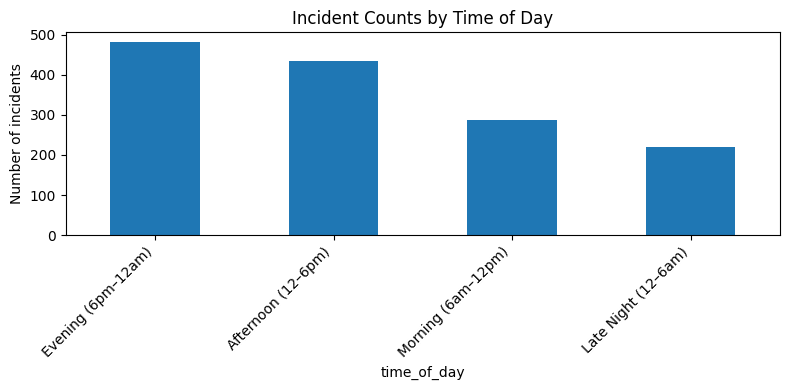

In [ ]:
tod_counts = df["time_of_day"].value_counts()
print(tod_counts)

tod_counts.plot(kind="bar")
plt.title("Incident Counts by Time of Day")
plt.ylabel("Number of incidents")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
ct_type_tod = pd.crosstab(df_top["Incident type"], df_top["time_of_day"])
print(ct_type_tod)

chi2, p, dof, expected = chi2_contingency(ct_type_tod)
print("\nChi-square test: Incident type vs Time of Day")
print(f"chi2 = {chi2:.2f}, dof = {dof}, p = {p:.4g}")


time_of_day                              Afternoon (12–6pm)  \
Incident type                                                 
Elevator Problem                                         27   
Fire Alarm                                               22   
Incomplete/Accidental Landline 911 Call                  66   
Incomplete/Accidental Wireless 911 Call                  33   
Medical Aid                                              38   
Noise Disturbance                                         0   
Petty Theft - Micro Mobility Device                      19   
Security Alarm                                            8   
Suspicious Person                                        10   
Welfare Check                                            16   

time_of_day                              Evening (6pm–12am)  \
Incident type                                                 
Elevator Problem                                         19   
Fire Alarm                                            

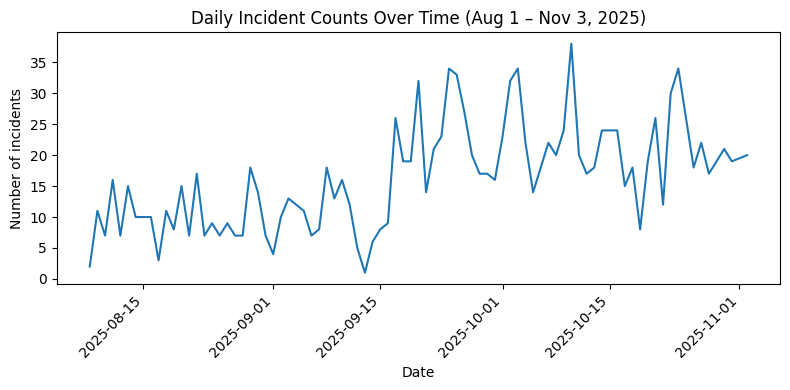

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     49.03
Date:                Tue, 02 Dec 2025   Prob (F-statistic):           5.77e-10
Time:                        22:31:49   Log-Likelihood:                -284.10
No. Observations:                  86   AIC:                             572.2
Df Residuals:                      84   BIC:                             577.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7033      1.424      5.409      0.0

In [ ]:
# Make sure datetime_occurred exists
# df["datetime_occurred"] = pd.to_datetime(...)

# Filter rows between 2025-08-01 and 2025-11-03 (inclusive)
start_date = pd.to_datetime("2025-08-01")
end_date   = pd.to_datetime("2025-11-03")

mask = (df["datetime_occurred"] >= start_date) & (df["datetime_occurred"] <= end_date)
df_range = df.loc[mask].copy()

# Daily incident counts on this restricted range
df_range["date_only"] = df_range["datetime_occurred"].dt.date
daily_counts = df_range.groupby("date_only").size()

daily_counts.plot()
plt.title("Daily Incident Counts Over Time (Aug 1 – Nov 3, 2025)")
plt.ylabel("Number of incidents")
plt.xlabel("Date")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Linear trend on the restricted range
ts_df = daily_counts.reset_index(name="count").rename(columns={"date_only": "date"})
ts_df["t"] = np.arange(len(ts_df))

import statsmodels.api as sm
X = sm.add_constant(ts_df["t"])
y = ts_df["count"]
ts_model = sm.OLS(y, X).fit()
print(ts_model.summary())



In [ ]:
# Narrow this down later, just a temp CI analysis

# Example: petty theft overall
petty_mask = df["Incident type"].str.contains("Petty Theft", case=False, na=False)
n_total = len(df)
n_petty = petty_mask.sum()

prop = n_petty / n_total
ci_low, ci_high = proportion_confint(
    count=n_petty, nobs=n_total, alpha=0.05, method="wilson"
)

print(f"Proportion of incidents that are petty theft: {prop:.3f}")
print(f"95% CI (Wilson): [{ci_low:.3f}, {ci_high:.3f}]")

# Example: compare proportion of petty theft in Main vs all other Zones combined
main_mask = (df["Zone"] == "Main")
other_mask = (df["Zone"] != "Main")

n_main = main_mask.sum()
n_main_petty = (main_mask & petty_mask).sum()

n_other = other_mask.sum()
n_other_petty = (other_mask & petty_mask).sum()

print("\nMain Zone petty theft:")
print(f"{n_main_petty}/{n_main}")

print("Other Zones petty theft:")
print(f"{n_other_petty}/{n_other}")

ci_main = proportion_confint(n_main_petty, n_main, alpha=0.05, method="wilson")
ci_other = proportion_confint(n_other_petty, n_other, alpha=0.05, method="wilson")

print(f"95% CI (Main):  [{ci_main[0]:.3f}, {ci_main[1]:.3f}]")
print(f"95% CI (Other): [{ci_other[0]:.3f}, {ci_other[1]:.3f}]")


Proportion of incidents that are petty theft: 0.084
95% CI (Wilson): [0.071, 0.099]

Main Zone petty theft:
43/390
Other Zones petty theft:
78/1051
95% CI (Main):  [0.083, 0.145]
95% CI (Other): [0.060, 0.092]


In [ ]:
# CI for differences in proportions (Main vs Other Zones)
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

count = np.array([n_main_petty, n_other_petty])
nobs = np.array([n_main, n_other])

# Z-test and CI for difference
stat, pval = proportions_ztest(count, nobs)
ci_low, ci_high = confint_proportions_2indep(
    count1=n_main_petty, nobs1=n_main,
    count2=n_other_petty, nobs2=n_other,
    method="wald"
)

print("Z-test p-value:", pval)
print("95% CI for difference:", ci_low, ci_high)

#If CI does not include 0, proportions are statistically different.

# If CI is entirely positive, Main Zone has higher rate.

# If entirely negative, Main Zone has lower rate.

#Interpretation

# There is a statistically significant difference between the proportion of petty theft incidents in the Main Zone compared to all other zones combined (p = 0.028 < 0.05).

# Because the entire confidence interval is positive, it means:

# Petty theft occurs more frequently in the Main Zone.

# More specifically:

# The increase in petty-theft proportion in the Main Zone is between
# 0.12 percentage points and 7.1 percentage points.

# Because the CI does not include zero, this difference is unlikely to be due to chance.

# The Main Zone experiences a slightly but statistically higher rate of petty theft than the rest of the zones. The effect is not huge, but it is real and statistically supported.

Z-test p-value: 0.02839889015682053
95% CI for difference: 0.0011500859174391406 0.07093266799214634


In [ ]:
#CI for mean incident counts per day / per zone
daily_counts = df.groupby("datetime_occurred").size()
mean_daily = daily_counts.mean()
std_daily = daily_counts.std()
n_days = len(daily_counts)

ci_low = mean_daily - 1.96 * (std_daily / np.sqrt(n_days))
ci_high = mean_daily + 1.96 * (std_daily / np.sqrt(n_days))

print("Mean daily incidents:", mean_daily)
print("95% CI:", ci_low, ci_high)

# Interpretation:

# The average number of reported incidents per day is approximately 1.02 incidents/day.

# The 95% CI is extremely narrow (1.010–1.024), which tells us:

# The true daily incident rate is almost certainly between 1.01 and 1.02.
# There is very little day-to-day variance in total incident volume.
# Incident reporting appears stable and consistent over time.

# In practical terms:

# On a typical day, there is essentially one incident per day at the venue.

# The stability and tight confidence interval indicate that the system does not experience large fluctuations in total incident volume, reinforcing the reliability of the data.

Mean daily incidents: 1.0171184022824535
95% CI: 1.0103260653677149 1.0239107391971922


TIME SERIES ANALYSIS
